# Interpolatiing Barium on a sphere

* A notebook of my work on interpolation from field obs. to grided data for the model run.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Content
1. [**Barium Samples**](#Barium-Samples)
  2. [GIPY 2007-11](#GIPY-2007-11)
  2. [BGEP 2003-2005](#BGEP-2003-2005)
  2. [CLIVAR Carbon and Hydrographic Data center](#CLIVAR-Carbon-and-Hydrographic-Data-center)
1. [**Interpolation**](#Interpolation)
  2. [Reconstruct vertical profiles](#Reconstruct-vertical-profiles)
  2. [Horizontal frame](#Horizontal-frame)
    3. [Projection transformation](#Projection-transformation)
    3. [Interpolating each layer](#Interpolating-each-layer)
1. [**Remap on ORCA2 frame**](#Remap-on-ORCA2-frame)
  2. [Plot](#Plot)

In [2]:
import sys
sys.path.insert(0, '_libs/')

In [3]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
from NEMO_tools import int_profile, bin_profile
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
% matplotlib inline

In [4]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

In [5]:
def check_bounds(out, bounds_low, bounds_up):
    '''
    "What out of bounds becomes nan"
    '''
    out_adj = np.copy(out)
    for i in range(133):
        for j in range(17):
            if((out[i, j]<bounds_low[j]) | (out[i, j]>bounds_up[j])):
                out_adj[i, j]=np.nan
    return out_adj

In [6]:
def remove_nan(x, y, data):
    '''
    "Kriging does not like nan"
    '''
    data_temp = data[~np.isnan(data)]
    x_temp = x[~np.isnan(data)]
    y_temp = y[~np.isnan(data)]
    return x_temp, y_temp, data_temp

# Barium Samples

Only the sample labeled as **good** will be perserved ("moderate", "questionable", "unkonwn" etc. will not)

## GIPY 2007-11

* Data is collected from Jul 2007 to Sep 2007
* Only the "good" data points selected
* CTD depth above 15m as "surface"

In [7]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/GIPY11_Ba.mat')
GIPY_lons = MAT['Ba_records'][:, 0]
GIPY_lats = MAT['Ba_records'][:, 1]
GIPY_deps = MAT['Ba_records'][:, 2]
GIPY_Ba   = MAT['Ba_records'][:, 3]
#
GIPY_lons[GIPY_lons>180]=GIPY_lons[GIPY_lons>180]-360

## BGEP 2003-2005

* http://www.whoi.edu/page.do?pid=66521
* Data collected at the summer of 2003, 2004, 2005
* Only "Good" data points selected
* CTD depth above 15m as "surface"

In [8]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/BGEP_Ba.mat')
x03 = MAT['Ba2003'][:, 1]; y03 = MAT['Ba2003'][:, 0]; z03 = MAT['Ba2003'][:, 2]; Ba03 = MAT['Ba2003'][:, 3]
x04 = MAT['Ba2004'][:, 1]; y04 = MAT['Ba2004'][:, 0]; z04 = MAT['Ba2004'][:, 2]; Ba04 = MAT['Ba2004'][:, 3]
x04[Ba04<0]=np.nan; y04[Ba04<0]=np.nan; z04[Ba04<0]=np.nan; Ba04[Ba04<0]=np.nan
x05 = MAT['Ba2005'][:, 1]; y05 = MAT['Ba2005'][:, 0]; z05 = MAT['Ba2005'][:, 2]; Ba05 = MAT['Ba2005'][:, 3]

## CLIVAR Carbon and Hydrographic Data center

http://www.clivar.org/resources/data/hydrographic

* HLY0301-32H120030721, Kelley Falkner http://seahunt.ucsd.edu/cruise/32H120030721
* CBL-32PZ20020819,  Rebecca Woodgate http://seahunt.ucsd.edu/cruise/32PZ20020819
* ARK-IX_4_1993-06AQ19930806, D.K. Fütterer http://seahunt.ucsd.edu/cruise/06AQ19930806

In [9]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/HLY_Ba.mat')
xH = np.squeeze(MAT['lon'][:]); yH = np.squeeze(MAT['lat'][:]); zH = np.squeeze(MAT['dep'][:]); BaH = np.squeeze(MAT['Ba'][:])

In [10]:
MAT = scipy.io.loadmat('../../Arctic-obs/MATLAB files/CBL_Ba.mat')
xC = np.squeeze(MAT['lon'][:]); yC = np.squeeze(MAT['lat'][:]); zC = np.squeeze(MAT['dep'][:]); BaC = np.squeeze(MAT['Ba'][:])

#Interpolation

## Reconstruct vertical profiles

In [11]:
nc_name=glob.glob('_data/NEMO/ORCA2_LIM_PISCES/ORCA2_5d_19700101_19701231_ptrc_T*')
nc_obj=nc.Dataset(nc_name[0])
deptht = nc_obj.variables['deptht'][:]

In [12]:
#deptht = np.array([5, 15, 25, 35, 45, 55, 75, 95, 115, 142, 182, 320, 511, 732, 1033, 1406, 1831, 2290, 2768, 3257, 3752, 4250, 4750, 5250]) 

In [13]:
x_all = np.hstack((GIPY_lons, x03, x04, x05, xH, xC))
y_all = np.hstack((GIPY_lats, y03, y04, y05, yH, yC))
z_all = np.hstack((GIPY_deps, z03, z04, z05, zH, zC))
Ba_all = np.hstack((GIPY_Ba, Ba03, Ba04, Ba05, BaH, BaC))

In [14]:
tar_dep = 5250
dep_surf = deptht[deptht<tar_dep]

In [15]:
x_surf = x_all[z_all<tar_dep]; y_surf = y_all[z_all<tar_dep]; z_surf = z_all[z_all<tar_dep]; Ba_surf = Ba_all[z_all<tar_dep]

In [16]:
locx, locy, out_surf = int_profile(x_surf, y_surf, z_surf, Ba_surf, dep_surf, thres=2000)

In [17]:
x_GIPY = GIPY_lons[GIPY_deps<tar_dep]; y_GIPY = GIPY_lats[GIPY_deps<tar_dep]
z_GIPY = GIPY_deps[GIPY_deps<tar_dep]; Ba_GIPY = GIPY_Ba[GIPY_deps<tar_dep]
#
x_03 = x03[z03<tar_dep]; y_03 = y03[z03<tar_dep]; z_03 = z03[z03<tar_dep]; Ba_03 = Ba03[z03<tar_dep]
x_04 = x04[z04<tar_dep]; y_04 = y04[z04<tar_dep]; z_04 = z04[z04<tar_dep]; Ba_04 = Ba04[z04<tar_dep]
x_05 = x05[z05<tar_dep]; y_05 = y05[z05<tar_dep]; z_05 = z05[z05<tar_dep]; Ba_05 = Ba05[z05<tar_dep]
x_H = xH[zH<tar_dep];    y_H = yH[zH<tar_dep];    z_H = zH[zH<tar_dep];    Ba_H = BaH[zH<tar_dep]
x_C = xC[zC<tar_dep];    y_C = yC[zC<tar_dep];    z_C = zC[zC<tar_dep];    Ba_C = BaC[zC<tar_dep]

In [18]:
locx_GIPY, locy_GIPY, out_GIPY = int_profile(x_GIPY, y_GIPY, z_GIPY, Ba_GIPY, dep_surf, thres=2)
locx_03, locy_03, out_03 = int_profile(x_03, y_03, z_03, Ba_03, dep_surf, thres=2)
locx_04, locy_04, out_04 = int_profile(x_04, y_04, z_04, Ba_04, dep_surf, thres=2)
locx_05, locy_05, out_05 = int_profile(x_05, y_05, z_05, Ba_05, dep_surf, thres=2)
locx_H, locy_H, out_H    = int_profile(x_H, y_H, z_H, Ba_H, dep_surf, thres=2)
locx_C, locy_C, out_C    = int_profile(x_C, y_C, z_C, Ba_C, dep_surf, thres=2)

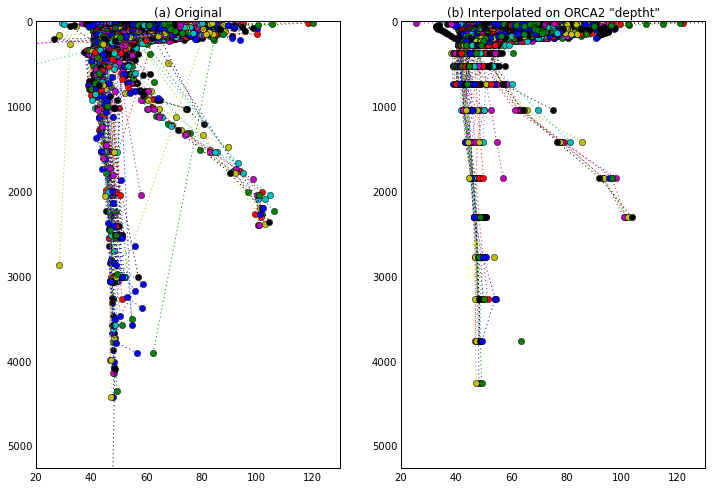

In [19]:
fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

AX = [ax1, ax2]
for i in range(2):
    AX[i].set_ylim(-10, tar_dep); AX[i].set_xlim(20, 130); AX[i].invert_yaxis()
    AX[i].xaxis.set_tick_params(size=0)
    AX[i].yaxis.set_tick_params(size=0)

for i in range(len(locx)):
    ax1.plot(Ba_all[x_all==locx[i]], z_all[x_all==locx[i]], 'o:')
ax1.set_title('(a) Original', fontsize=12)

ax2.plot(out_surf.T, dep_surf, 'o:')
ax2.set_title('(b) Interpolated on ORCA2 "deptht"')

## Horizontal frame

### Projection transformation

<img src="_figures/Projxy.PNG" width=450 align="left"/>

*The reference surface with geographic coordinates $\mathsf{(\phi,\lambda)}$ is projected onto a 2D Cartesian plane $\mathsf{(x, y)}$.*

In [84]:
p1=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90)
# create frame
listx_trans = np.linspace(1.1e7, 1.5e7, 100)
listy_trans = np.linspace(1.1e7, 1.5e7, 100)
gridx_trans, gridy_trans = np.meshgrid(listx_trans, listy_trans)
# convert frame back to lat/lon
listx, listy = p1(listx_trans, listy_trans, inverse=True)
gridx, gridy = p1(gridx_trans, gridy_trans, inverse=True)

In [85]:
# for CTD's locs
x_trans, y_trans = p1(locx, locy)
x_GIPY_trans, y_GIPY_trans = p1(locx_GIPY, locy_GIPY)
x03_trans, y03_trans = p1(locx_03, locy_03)
x04_trans, y04_trans = p1(locx_04, locy_04)
x05_trans, y05_trans = p1(locx_05, locy_05)
xH_trans , yH_trans  = p1(locx_H , locy_H)
xC_trans , yC_trans  = p1(locx_C , locy_C)

### Interpolating each layer

In [86]:
for i in range(3):
    x_temp, y_temp, Ba_temp = remove_nan(x_trans, y_trans, Ba_all_int[:, i])
    # Just to plot cruises saperately
    x_GIPY_temp, y_GIPY_temp, _ = remove_nan(x_GIPY_trans, y_GIPY_trans, out_GIPY[:, i])
    x03_temp, y03_temp, _ = remove_nan(x03_trans, y03_trans, out_03[:, i])
    x04_temp, y04_temp, _ = remove_nan(x04_trans, y04_trans, out_04[:, i])
    x05_temp, y05_temp, _ = remove_nan(x05_trans, y05_trans, out_05[:, i])
    xH_temp, yH_temp, _ = remove_nan(xH_trans, yH_trans, out_H[:, i])
    xC_temp, yC_temp, _ = remove_nan(xC_trans, yC_trans, out_C[:, i])
    print('data points participated: {}'.format(len(Ba_temp)))# Check the the number of data
    # Kriging
    OK = OrdinaryKriging(x_temp, y_temp, Ba_temp, variogram_model='linear', verbose=False, enable_plotting=False)
    Ba_int, ss = OK.execute('grid', listx_trans, listy_trans) # (gridx_trans, gridy_trans, Ba_int)
    # Plot
    fig=plt.figure(figsize=(10, 10))
    ax=fig.gca()
    ax.set_xlim(1.1e7, 1.5e7)
    ax.set_ylim(1.1e7, 1.5e7)
    CS = ax.pcolor(gridx_trans, gridy_trans, Ba_int, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    ax.plot(x_GIPY_temp, y_GIPY_temp, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
    ax.plot(x03_temp, y03_temp, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
    ax.plot(x04_temp, y04_temp, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
    ax.plot(x05_temp, y05_temp, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
    ax.plot( xH_temp,  yH_temp, 'k>', ms=6, mew=0.5, label='HLY0301 2003 obs.')
    ax.plot( xC_temp,  yC_temp, 'k<', ms=6, mew=0.5, label='CBL 2002 obs.') 
    CBar = plt.colorbar(CS, shrink=0.575)
    CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    LG = ax.legend(numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
    ax.set_title('Interpolated Barium | deptht('+str(i)+')', fontsize=15, y=1.025)    
    #fig.savefig('Publish/Barium_layer_'+str(i)+'modified.pdf', dpi=400, orientation='portrait', papertype='a4', format='pdf',
    #        transparent=False, bbox_inches='tight', pad_inches=0)

data points participated: 158


MemoryError: 

In [26]:
## Save
#save_var = { 'Ba_int': Ba_int, 'lon': gridx, 'lat': gridy}#, 'lon_trans':gridx_trans, 'lat_trans':gridy_trans  }
#scipy.io.savemat('_data/Exchange/Temp_Ba_int.mat', mdict=save_var)

# Remap on ORCA2 frame

In [28]:
coordinate_name=glob.glob('_data/NEMO/ORCA2_INPUT/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [29]:
Ba_ini_orca = Nts.reporj_NEMOgrid(gridx, gridy, Ba_int, nav_lon, nav_lat, method='linear')

In [30]:
hit = find_inland(nav_lon, nav_lat); Ba_ini_orca[hit==1]=np.nan
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

## Plot

In [31]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [32]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

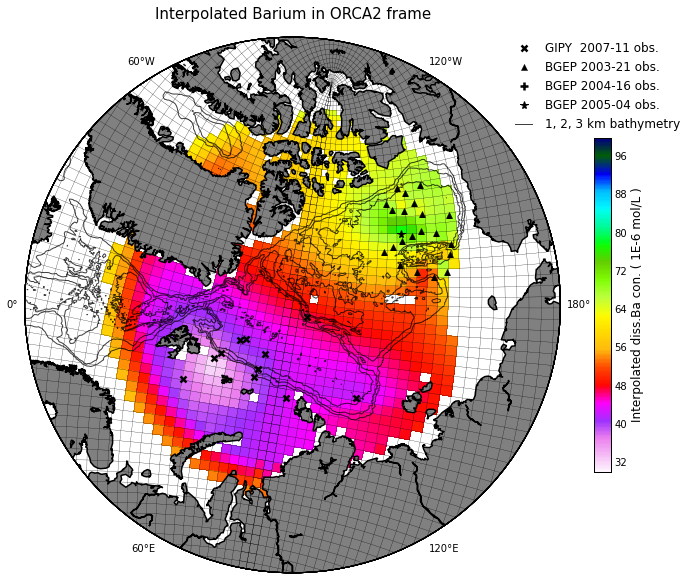

In [34]:
clevs=[1000, 2000, 3000]
fig=plt.figure(figsize=(12, 12)); ax=plt.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=65, lon_0=90, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
proj.drawcoastlines(linewidth=1.5, color='k')
gridx, gridy = proj(nav_lon, nav_lat)
GIPYx_trans, GIPYy_trans = proj(GIPY_x, GIPY_y)
BGEP03x_trans, BGEP03y_trans = proj(BGEP03_x, BGEP03_y)
BGEP04x_trans, BGEP04y_trans = proj(BGEP04_x, BGEP04_y)
BGEP05x_trans, BGEP05y_trans = proj(BGEP05_x, BGEP05_y)
topox, topoy = proj(lon_arctic, lat_arctic)
CS = proj.pcolor(gridx, gridy, Ba_ini_masked, vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
CS2.collections[0].set_label('1, 2, 3 km bathymetry')
proj.plot(  GIPYx_trans, GIPYy_trans, 'kx', ms=6, mew=2.5, label='GIPY  2007-11 obs.')
proj.plot(BGEP03x_trans, BGEP03y_trans, 'k^', ms=6, mew=0.5, label='BGEP 2003-21 obs.')
proj.plot(BGEP04x_trans, BGEP04y_trans, 'k+', ms=8, mew=2.5, label='BGEP 2004-16 obs.')
proj.plot(BGEP05x_trans, BGEP05y_trans, 'k*', ms=8, mew=1.0, label='BGEP 2005-04 obs.')
proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
proj.plot(gridx, gridy, 'k-', lw=0.25)
CBar = plt.colorbar(CS, shrink=0.5)
CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
ax.set_title('Interpolated Barium in ORCA2 frame', fontsize=15, y=1.025)
#fig.savefig('Publish/Barium_4.pdf', dpi=600, orientation='portrait', papertype='a4', format='pdf',
#            transparent=False, bbox_inches='tight', pad_inches=0)

**Compare with Guay (1997)'s work'**

<img src="_figures/Gauy_Ba_map.PNG" width=650 align="left"/>